# Response Factor Method for Solving Wall Heat Transfer
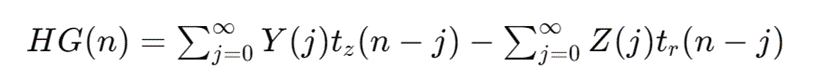

In [15]:
import numpy as np
import pandas as pd
import re
import sympy as sp
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt
from numpy.lib.scimath import sqrt as csqrt
from scipy.optimize import root

# Define variable s
s = sp.symbols('s')

# Define thermal properties of each layer of the wall
lambda_values = [0.81, 0.7]  # Thermal conductivity of materials (W/(m·K))
thickness = [0.24, 0.0]  # Material thickness (m)
a = [0.00184, 0.00179]  # Thermal diffusivity (m^2/h)
h = [23.3, 8.7]  # Heat transfer coefficients on both sides (W/(m^2))

# Calculate the heat transfer coefficient of the composite wall
R_layers = [th / lam for th, lam in zip(thickness, lambda_values)]
R_side1 = 1 / h[0]  # Calculate the thermal resistance on both sides
R_side2 = 1 / h[1]
R_total = R_side1 + sum(R_layers) + R_side2
K = 1 / R_total

# Define time interval
Delta_tau = 1  # Unit hour

# Define transfer function matrix
M1 = sp.Matrix([[1, 1/h[0]], [0, 1]])

M2 = sp.Matrix([
    [sp.cosh(sp.sqrt(s / a[0]) * thickness[0]), sp.sinh(sp.sqrt(s / a[0]) * thickness[0]) / (lambda_values[0] * sp.sqrt(s / a[0]))],
    [lambda_values[0] * sp.sqrt(s / a[0]) * sp.sinh(sp.sqrt(s / a[0]) * thickness[0]), sp.cosh(sp.sqrt(s / a[0]) * thickness[0])]
])

M3 = sp.Matrix([
    [sp.cosh(sp.sqrt(s / a[1]) * thickness[1]), sp.sinh(sp.sqrt(s / a[1]) * thickness[1]) / (lambda_values[1] * sp.sqrt(s / a[1]))],
    [lambda_values[1] * sp.sqrt(s / a[1]) * sp.sinh(sp.sqrt(s / a[1]) * thickness[1]), sp.cosh(sp.sqrt(s / a[1]) * thickness[1])]
])

M4 = sp.Matrix([[1, 1/h[1]], [0, 1]])

# Calculate the transfer function [D B; C A]
N1 = M1 * M2
N2 = M3 * M4
R = N1 * N2

# Corrected indexing for accessing elements of matrix R
A_s = R[1, 1]  # Access the element in the second row, second column
B_s = R[0, 1]  # Access the element in the first row, second column
C_s = R[1, 0]  # Access the element in the second row, first column
D_s = R[0, 0]  # Access the element in the first row, first column

# Convert these symbolic expressions to callable Python functions
A_s_func = sp.lambdify(s, A_s)
B_s_func = sp.lambdify(s, B_s)
C_s_func = sp.lambdify(s, C_s)
D_s_func = sp.lambdify(s, D_s)

def equation(s):
    s = complex(s[0], s[1])  # Convert input to complex number
    if np.abs(s) < 1e-10:
        return [np.inf, np.inf]  # Return a large number, indicating this area is not suitable for root calculation
    result = B_s_func(s)
    return [np.real(result), np.imag(result)]

# Find all roots
roots = []
# Interval division and starting point generation
for start in np.linspace(-1500, 0, 5000):  # Generate more starting points within the interval
    initial_guess = [start, 0]
    sol = root(equation, initial_guess, method='hybr')
    # Check if the solution is a new root
    if sol.success and not any(np.allclose(sol.x, existing_root, atol=1e-2) for existing_root in roots):
        # Additional check to ensure the root is within a desired range, for example:
        if -1500 <= sol.x[0] <= 0:
            # Verify the equation's result at the root is close to zero
            if np.allclose(equation(sol.x), [0, 0], atol=1e-2):
                roots.append(sol.x)
                print(f"New root found: {sol.x}")

# Output all found roots
print("Found roots are:")
for r in roots:
    print(r)


root_value = []  # Initialize an empty list

for r in roots:
    modified_root =  r[0]  
    root_value.append(modified_root)  # Append the modified root to the list

root_value = np.sort(root_value)[::-1]

df = pd.DataFrame(root_value, columns=["Modified Roots"])

# Save the DataFrame to a CSV file
df.to_csv("root_value.csv", index=False)

def read_array_from_file(file_path):
    # Open the file and read the content
    with open(file_path, 'r') as file:
        data = file.read()
        
    # Use a regular expression to extract numbers within the array
    numbers = re.findall(r"[-+]?\d*\.\d+|\d+", data)
    array = list(map(float, numbers))
    return array

# File path
file_path = 'root_value.csv'
# Read and create array
array = read_array_from_file(file_path)

modules = [{"sqrt": np.lib.scimath.sqrt, "sinh": np.sinh, "cosh": np.cosh}, "numpy"]
B_prime = sp.lambdify(s, sp.diff(B_s, s), modules=modules)
A_s_func = sp.lambdify(s, A_s, modules=modules)
B_s_func = sp.lambdify(s, B_s, modules=modules)
D_s_func = sp.lambdify(s, D_s, modules=modules)


# Calculate coefficients
Ai = []
Bi = []
Ci = []

for root in array:
    derivative_at_root = np.real(B_prime(root))
    A_derivative_at_root = np.real(A_s_func(root))
    D_derivative_at_root = np.real(D_s_func(root))
    
    if derivative_at_root * root**2 == 0:
        print(f"Skip root {root} because of zero division risk.")
        continue
    
    # Calculate coefficients and retain the real part
    Ai_val = np.real(-A_derivative_at_root / (derivative_at_root * root**2))
    Bi_val = np.real(-1 / (derivative_at_root * root**2))
    Ci_val = np.real(-D_derivative_at_root / (derivative_at_root * root**2))
    
    Ai.append(Ai_val)
    Bi.append(Bi_val)
    Ci.append(Ci_val)

# Calculate response coefficients Y X Z

alpha = np.array(array)
alpha = -1*alpha
j_max = len(alpha)

# Initialize Y X Z arrays
Y = np.zeros(j_max + 1)  # Python indexing starts at 0
X = np.zeros(j_max + 1)
Z = np.zeros(j_max + 1)

# Calculate Y(0)
Y[0] = K  # Initialize Y(0)
for i in range(len(Bi)):
    # print(Bi[i])
    Y[0] =  Y[0] + Bi[i] / Delta_tau * (1 - np.exp(-alpha[i] * Delta_tau))


# Calculate Y(j) for j >= 1
for j in range(1, j_max + 1):
    Y[j] = 0  # Initialize Y(j)
    for i in range(len(Bi)):
        Y[j] -= (Bi[i] / Delta_tau) * (1 - np.exp(-alpha[i] * Delta_tau))**2 * np.exp(-alpha[i] * (j - 1) * Delta_tau)

# Calculate Z(0)
Z[0] = K  # Initialize Z(0)
for i in range(len(Bi)):
    Z[0] += Ci[i] / Delta_tau * (1 - np.exp(-alpha[i] * Delta_tau))

# Calculate Z(j) for j >= 1
for j in range(1, j_max + 1):
    Z[j] = 0  # Initialize Z(j)
    for i in range(len(Bi)):
        Z[j] -= (Ci[i] / Delta_tau) * (1 - np.exp(-alpha[i] * Delta_tau))**2 * np.exp(-alpha[i] * (j - 1) * Delta_tau)

# Calculate X(0)
X[0] = K  # Initialize X(0)
for i in range(len(Bi)):
    X[0] += Ai[i] / Delta_tau * (1 - np.exp(-alpha[i] * Delta_tau))

# Calculate X(j) for j >= 1
for j in range(1, j_max + 1):
    X[j] = 0  # Initialize X(j)
    for i in range(len(Bi)):
        X[j] -= (Ai[i] / Delta_tau) * (1 - np.exp(-alpha[i] * Delta_tau))**2 * np.exp(-alpha[i] * (j - 1) * Delta_tau)

# Read the temperature data from Excel
df = pd.read_excel('Integrated Temperature for test2.xlsx')
t_o = df.to_numpy().flatten()  # Assuming the data is in a single column or row
t_i = 24 * np.ones(24)  # Indoor temperature

N = len(t_o) // 24  # Calculate the period
add_N = np.ceil(len(alpha) / 24).astype(int)

# Extend t_o to ensure it covers all indices that will be accessed
extended_size = (N + add_N) * 24  # This ensures that we cover the whole range
t_o = np.tile(t_o[:24], (N + add_N))
t_i = np.tile(t_i, (N + add_N))

n = 24 * N  # Calculate up to the nth time point
HG = np.zeros(n)  # Initialize HG

# Ensure t_o and t_i have the necessary length
if len(t_o) < extended_size:
    t_o = np.concatenate((t_o, np.tile(t_o[:24], extended_size // len(t_o) + 1)[:extended_size - len(t_o)]))
if len(t_i) < extended_size:
    t_i = np.concatenate((t_i, np.tile(t_i[:24], extended_size // len(t_i) + 1)[:extended_size - len(t_i)]))

# Compute HG(n)
for k in range(n):
    sum_Y = 0
    sum_Z = 0
    i = k + 24 * add_N
    for j in range(1, j_max + 1):  # Adjusted index for Python (0-based)
        if i - j < len(t_o):  # Check if the index is within bounds
            sum_Y += Y[j-1] * t_o[i - j]
            sum_Z += Z[j-1] * t_i[i - j]
    HG[k] = sum_Y - sum_Z


New root found: [-1458.45576939     0.        ]
New root found: [-1212.53808095     0.        ]
New root found: [-386.82172832    0.        ]
New root found: [-1173.75875142     0.        ]
New root found: [-1098.09176516     0.        ]
New root found: [-1373.96097571     0.        ]
New root found: [-1415.89309367     0.        ]
New root found: [-1332.65941547     0.        ]
New root found: [-247.78320428    0.        ]
New root found: [-639.04528462    0.        ]
New root found: [-667.73569825    0.        ]
New root found: [-583.55612688    0.        ]
New root found: [-1135.6099795     0.       ]
New root found: [-1291.98841295     0.        ]
New root found: [-1061.20410837     0.        ]
New root found: [-1251.94796812     0.        ]
New root found: [-788.80292061    0.        ]
New root found: [-820.64611865    0.        ]
New root found: [-886.22418623    0.        ]
New root found: [-167.38642278    0.        ]
New root found: [-556.75738246    0.        ]
New root found

<lambdifygenerated-34>:2: RuntimeWarning: overflow encountered in sinh
  return 0.0931538768036424*sqrt(s)*sinh(5.59502884944188*sqrt(s)) + 0.157860983671255*cosh(5.59502884944188*sqrt(s)) + 0.0529570631840178*sinh(5.59502884944188*sqrt(s))/sqrt(s)
<lambdifygenerated-34>:2: RuntimeWarning: invalid value encountered in scalar multiply
  return 0.0931538768036424*sqrt(s)*sinh(5.59502884944188*sqrt(s)) + 0.157860983671255*cosh(5.59502884944188*sqrt(s)) + 0.0529570631840178*sinh(5.59502884944188*sqrt(s))/sqrt(s)
<lambdifygenerated-34>:2: RuntimeWarning: overflow encountered in cosh
  return 0.0931538768036424*sqrt(s)*sinh(5.59502884944188*sqrt(s)) + 0.157860983671255*cosh(5.59502884944188*sqrt(s)) + 0.0529570631840178*sinh(5.59502884944188*sqrt(s))/sqrt(s)
<lambdifygenerated-34>:2: RuntimeWarning: invalid value encountered in scalar divide
  return 0.0931538768036424*sqrt(s)*sinh(5.59502884944188*sqrt(s)) + 0.157860983671255*cosh(5.59502884944188*sqrt(s)) + 0.0529570631840178*sinh(5.595028

New root found: [-610.98542755    0.        ]
New root found: [-102.75300819    0.        ]
New root found: [-284.35574047    0.        ]
New root found: [-323.45047845    0.        ]
New root found: [-62.39527658   0.        ]
New root found: [-432.22199706    0.        ]
New root found: [-505.05156165    0.        ]
New root found: [-32.12373762   0.        ]
New root found: [-343.94367534    0.        ]
New root found: [-38.74625805   0.        ]
New root found: [-265.75419768    0.        ]
New root found: [-213.73286024    0.        ]
New root found: [-153.19868731    0.        ]
New root found: [-182.20469463    0.        ]
New root found: [-230.44275898    0.        ]
New root found: [-45.99895568   0.        ]
New root found: [-71.53902213   0.        ]
New root found: [-3.3646896  0.       ]
New root found: [-114.41865197    0.        ]
New root found: [-126.71480779    0.        ]
New root found: [-26.13123006   0.        ]
New root found: [-139.64148404    0.        ]
New ro

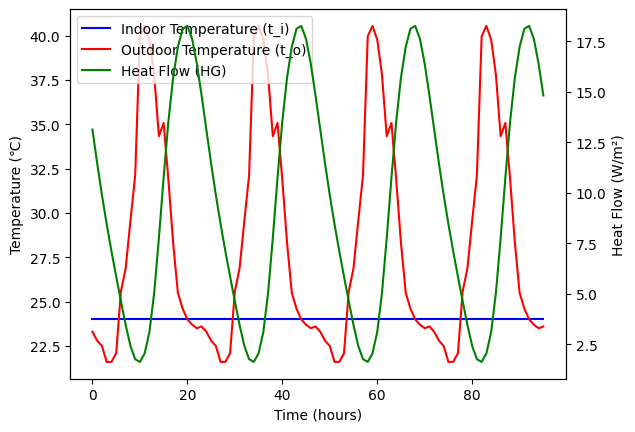

In [16]:
# Create a figure and an ax1 object
fig, ax1 = plt.subplots()

# Plot the first dataset using ax1 object and set axis labels
ax1.plot(t_i[add_N*24:], label='Indoor Temperature (t_i)', color='b')  # Assuming t_i is the indoor temperature
ax1.plot(t_o[add_N*24:], label='Outdoor Temperature (t_o)', color='r')  # Assuming t_o is the outdoor temperature
ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Temperature (℃)')

# Create an ax2 object that shares the x-axis but has its own y-axis
ax2 = ax1.twinx()
ax2.plot(HG, label='Heat Flow (HG)', color='g')  # Assuming HG is heat flow
ax2.set_ylabel('Heat Flow (W/m²)')

# Add a legend
# Because there are two different y-axes, manually specify each label's color to avoid confusion
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

# Display the plot
plt.show()